# GAN

### Discriminator 

A discriminator that tells how real an image is, is basically a deep Convolutional Neural Network (CNN) as shown in Figure 1. For MNIST Dataset, the input is an image (28 pixel x 28 pixel x 1 channel). The sigmoid output is a scalar value of the probability of how real the image is (0.0 is certainly fake, 1.0 is certainly real.

### Adversarial Model
adversarial model is just the generator-discriminator stacked together


In [7]:
! conda activate ml37

In [8]:
! conda list

# packages in environment at C:\Users\Sophie\Anaconda3:
#
# Name                    Version                   Build  Channel
_anaconda_depends         2020.02                  py37_0  
_ipyw_jlab_nb_ext_conf    0.1.0                    py37_0  
alabaster                 0.7.12                   py37_0  
anaconda                  custom                   py37_1  
anaconda-client           1.7.2                    py37_0  
anaconda-navigator        1.9.12                   py37_0  
anaconda-project          0.8.4                      py_0  
arcade                    2.4.1                    pypi_0    pypi
argh                      0.26.2                   py37_0  
asn1crypto                1.3.0                    py37_0  
astroid                   2.3.3                    py37_0  
astropy                   4.0.1.post1      py37he774522_1  
atomicwrites              1.4.0                      py_0  
attrs                     19.3.0                     py_0  
autopep8                  1.4

tqdm                      4.47.0                     py_0  
traitlets                 4.3.3                    py37_0  
typing_extensions         3.7.4.2                    py_0  
ujson                     1.35             py37hfa6e2cd_0  
unicodecsv                0.14.1                   py37_0  
urllib3                   1.25.9                     py_0  
vc                        14.1                 h0510ff6_4  
vs2015_runtime            14.16.27012          hf0eaf9b_3  
watchdog                  0.10.3                   py37_0  
wcwidth                   0.2.5                      py_0  
webencodings              0.5.1                    py37_1  
werkzeug                  1.0.1                      py_0  
wheel                     0.34.2                   py37_0  
widgetsnbextension        3.5.1                    py37_0  
win_inet_pton             1.1.0                    py37_0  
win_unicode_console       0.5                      py37_0  
wincertstore              0.2           

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyval2d

from sklearn.datasets import make_circles, make_moons, make_blobs 
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from tensorflow.keras.losses import mse, binary_crossentropy


import tensorflow as tf

from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras import backend as K
from keras import objectives

import time
import os
from IPython import display

### Creating images

- I just created the polynomial images with a size of 28x28 to avoid errors with dimesions

In [10]:
# create images
# numpy.polynomial.polynomial.polyval2d does what was written in forum on how to create images
# Row numbers in V correspond to powers of x, while column numbers in V correspond to powers of y

def my_polys(degree):
    coeff = np.random.uniform(0,1,(degree+1,degree+1))
    # p = polyval2d(x, y, coef) # returns one value
    p = [[sum([coeff[i,j]*((x/size)**i)*((y/size)**j)
            for i in range(degree+1) for j in range(degree+1) if (i+j)<=degree]) 
            for x in range(size)] for y in range(size)]
    return p

# one image
# x = np.linspace(0,1,40)
# y = np.linspace(0,1,40)
# x,y = np.meshgrid(x,y)
# image = my_polys(x,y,5)

maxdegree = 5
size = 28
num_polys = 1000 # number of 
dataset = np.array([my_polys(np.random.randint(0,maxdegree)) for i in range(num_polys)])
dataset = tf.keras.utils.normalize(dataset)

dataset = dataset.reshape(dataset.shape[0], 28, 28, 1).astype('float32')
print(np.shape(dataset))


# Batch and shuffle the data
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

(1000, 28, 28, 1)


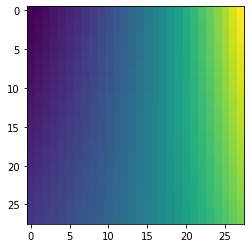

In [11]:

plt.imshow(dataset[10].reshape((28,28)))

In [12]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,), name="gen_layer1"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

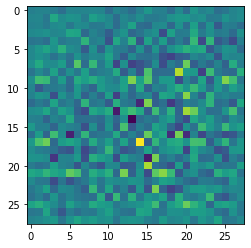

In [13]:
generator = make_generator_model()

#Let's check what our generator predicts

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [14]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_layer1 (Dense)           (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [15]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1], name="disc_layer1"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [16]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00101158]], shape=(1, 1), dtype=float32)


In [17]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
disc_layer1 (Conv2D)         (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [24]:
#Our losses

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # from_logits=True (we did not use sigmoid activation)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [25]:
# Our optimiser

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [20]:
# Our training

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime to visualise progress
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [21]:
# One training step

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    

# For saving images
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    
    predictions = model(test_input, training=False)
    fig = plt.figure()
    for i in range(predictions.shape[0]):
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')
    
#     predictions = model(test_input, training=False)
#     fig = plt.figure(figsize=(4,4))
#     for i in range(predictions.shape[0]):
#         plt.subplot(4, 4, i+1)
#         plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
#         plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    
    
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch + 1,seed)

        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
           #  checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator,epochs,seed)

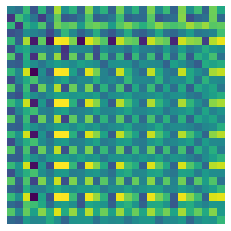

In [22]:
train(train_dataset, EPOCHS)

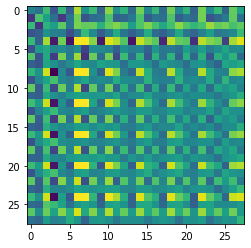

In [23]:
# create a random sample after training

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

- So this is what the generator creates after training. Does not look too good. Any suggestions how this can be improved? 
- Running this takes forever, would that be improved on a GPU? 